In [1]:
from random import randint
from ctypes import *
import timeit
import matplotlib.pyplot as plt

In [2]:
class Vertex:
    def __init__(self, x, y, wall):
        self.x = x
        self.y = y
        self.f = 0  # Total cost
        self.g = 0  # Distance from start vertex
        self.h = 0  # Determines shortest distance to end vertex (heuristic)
        self.neighbours = []
        self.previous = None
        # self.wall = True if randint(1, 100) < 20 else False
        self.wall = wall

    def add_neighbours(self, grid: list) -> None:
        """
        Gets adjacent walls
        :param grid: The grid to get neighbours from
        :return: None
        """
        self.neighbours.append(grid[self.y + 1][self.x]) if self.y < len(grid) - 1 else 0
        self.neighbours.append(grid[self.y - 1][self.x]) if self.y > 0 else 0
        self.neighbours.append(grid[self.y][self.x + 1]) if self.x < len(grid[0]) - 1 else 0
        self.neighbours.append(grid[self.y][self.x - 1]) if self.x > 0 else 0


class AStar:
    def __init__(self, cols, rows, from_file=True, is_maze=True):
        self.cols = cols
        self.rows = rows
        self.open_set = []  # Unchecked vertices
        self.closed_set = []  # Checked vertices
        self.is_maze = is_maze
        self.from_file = from_file
        if from_file:
            self.grid = self.load_from_file(is_maze)
        else:
            self.grid = [[Vertex(j, i, True if randint(1, 100) < 20 else False) for j in range(cols)] for i in range(rows)]

    @staticmethod
    def heuristic(a: Vertex, b: Vertex) -> int:
        """
        Get taxicab distance between two points
        |x1 - x2| + |y1 - y2|
        :param a: First vertex
        :param b: Second vertex
        :return: taxicab distance between a and b
        """
        return abs(a.x - b.x) + abs(a.y - b.y)

    def load_from_file(self, is_maze: bool, fn: str="maze.txt") -> list:
        """
        Load maze to solve from txt file generated by maze_creator.py
        :param is_maze: Determines whether to load a maze or other file
        :param fn: File name to load maze from
        :return: Maze grid
        """
        with open(fn if not is_maze else fn) as f:
            maze = [i.replace("\n", "") for i in f.readlines()]
        self.cols = len(maze[0])
        self.rows = len(maze)
        if is_maze:
            grid = [[Vertex(j, i, True if maze[i][j] in ["/", "-", "|"] else False) for j in range(len(maze[0]))] for i in range(len(maze))]
        else:
            grid = [[Vertex(j, i, True if maze[i][j] == "#" else False) for j in range(len(maze[0]))] for i in range(len(maze))]
        return grid

    def solve(self, start: tuple=None, end: tuple=None) -> tuple:
        """
        Solve maze using A*
        :param start: Start position to pathfind from
        :param end: End position to find
        :return: List containing all shortest path vertices and all visited vertices
        """
        # Get all neighbours of vertices in grid
        for row in self.grid:
            for v in row:
                v.add_neighbours(self.grid)

        # Start and end positions
        if start is None or end is None:
            start = self.grid[1 if self.is_maze else 0][1 if self.is_maze else 0]
            end = self.grid[(self.rows - 2) if self.is_maze else self.rows - 1][(self.cols - 2) if self.is_maze else self.cols - 1]
        else:
            start = self.grid[start[0]][start[1]]
            end = self.grid[end[0]][end[1]]

        if self.from_file and not self.is_maze:
            with open("maze.txt") as f:
                maze = [i for i in f.readlines()]
            for i in range(len(maze)):
                if "s" in maze[i]:
                    start_pos = maze[i].find("s")
                    start = self.grid[i][start_pos]
                if "e" in maze[i]:
                    end_pos = maze[i].find("e")
                    end = self.grid[i][end_pos]

        self.open_set.append(start)

        # While all vertices haven't been checked
        while self.open_set:
            smallest = 0
            for i in range(len(self.open_set)):
                if self.open_set[i].f < self.open_set[smallest].f:
                    smallest = i

            # Get current path using the vertices' parent vertex
            path = []
            current = self.open_set[smallest]
            temp = current

            # If current vertex is the end vertex then finish
            if current == end:
                path.append(temp)
                while temp.previous:
                    path.append(temp.previous)
                    temp = temp.previous

                return path, self.closed_set

            # Remove current vertex from open and add it to closed
            self.open_set.remove(current)
            self.closed_set.append(current)

            # Check neighbours for possible routes
            neighbours = current.neighbours
            for i in neighbours:
                neighbour = i
                if neighbour not in self.closed_set and not neighbour.wall:
                    temp_g = current.g + 1  # Neighbour distance from start is one more than current
                    # Trying to get smallest distance
                    if neighbour in self.open_set:
                        if temp_g < neighbour.g:
                            neighbour.g = temp_g
                    else:
                        neighbour.g = temp_g
                        self.open_set.append(neighbour)

                    # Assigning neighbour h and f values
                    neighbour.h = self.heuristic(neighbour, end)
                    neighbour.f = neighbour.g + neighbour.h
                    neighbour.previous = current

Compiled using: 
`g++ -c a_star.cpp -I/Users/Alw/AppData/Local/Programs/Python/Python37/include/`

`g++ -shared a_star.o -L/Users/Alw/AppData/Local/Programs/Python/Python37/libs/ -lpython37 -o a_star.dll`
```c++
#define PY_SSIZE_T_CLEAN
#include <Python.h>
#include <iostream>
#include <fstream>
#include <vector>
#include <string>
#include <algorithm>
#include <iterator>
#include <functional>
#include <array>
#include <set>
#define TwoDimVector(dataType) std::vector<std::vector<dataType>>

class Vertex {
    public:
        int x;
        int y;
        bool wall;
        int f = 0;
        int g = 0;
        int h = 0;
        std::vector<std::array<int, 2>> neighbours;
        std::array<int, 2> previous ={NULL, NULL};
        Vertex(int a=0, int b=0, bool w=false){
            x = a;
            y = b;
            wall = w;
        }
};

class AStar {
    public:
        int cols;
        int rows;
        TwoDimVector(Vertex) grid;
        int heuristic(int x1, int y1, int x2, int y2){
            return abs(x1 - x2) + abs(y1 - y2);
        }
        TwoDimVector(Vertex) create_grid(std::vector<std::string> maze){
            TwoDimVector(Vertex) g;
            rows = maze.size();
            cols = maze[0].length();
            g.resize(rows, std::vector<Vertex>(cols, 0));
            for(int i = 0; i < rows; i++){
                for(int j = 0; j < cols; j++){
                    bool is_wall;
                    // Use single quotes for characters
                    if(maze[i][j] == '/' || maze[i][j] == '|' || maze[i][j] == '-'){
                        is_wall = true;
                    }
                    else{
                        is_wall = false;
                    }
                    Vertex vert(j, i, is_wall);
                    g[i][j] = vert;
                }
            }
            return g;
        }
        std::vector<std::array<int, 2>> solve(int start_x, int start_y, int end_x, int end_y){
            std::vector<std::string> str_grid;

            // Get maze from text file
            std::string line;
            std::ifstream file("maze.txt");
            if(file.is_open()){
                while(std::getline(file, line)){
                    str_grid.push_back(line);
                }
                file.close();
            }

            grid = create_grid(str_grid);

            // Add neighbpurs
            for(int i = 0; i < rows; i++){
                for(int j = 0; j < cols; j++){
                    int x = grid[i][j].x, y = grid[i][j].y;
                    std::array<int, 2> arr;
                    if(y < rows - 1){
                        arr[0] = x;
                        arr[1] = y + 1;
                        grid[i][j].neighbours.push_back(arr);
                    }
                    if(y > 0){
                        arr[0] = x;
                        arr[1] = y - 1;
                        grid[i][j].neighbours.push_back(arr);
                    }
                    if(x < cols - 1){
                        arr[0] = x + 1;
                        arr[1] = y;
                        grid[i][j].neighbours.push_back(arr);
                    }
                    if(x > 0){
                        arr[0] = x - 1;
                        arr[1] = y;
                        grid[i][j].neighbours.push_back(arr);
                    }
                }
            }

            // Start and end positions
            std::array<int, 2> start = {start_x, start_y};
            std::array<int, 2> end = {end_x, end_y};


            // Create open set
            std::vector<std::array<int, 2>> open_set;
            std::set<std::array<int, 2>> closed_set;
            open_set.push_back(start);

            // Start main solving loop
            int smallest;
            while(open_set.size() > 0){
                smallest = 0;
                for(int i = 0; i < open_set.size(); i++){
                    if(grid[open_set[i][1]][open_set[i][0]].f < grid[open_set[smallest][1]][open_set[smallest][0]].f){
                        smallest = i;
                    }
                }
                // Create 
                std::vector<std::array<int, 2>> path;
                std::array<int, 2> current = {open_set[smallest][0], open_set[smallest][1]};
                std::array<int, 2> temp = {current[0], current[1]};

                // Return if the current and end positions are the same
                if (current[0] == end[0] && current[1] == end[1]){
                    path.push_back(temp);

                    // Get path using the previous positions
                    while(grid[temp[1]][temp[0]].previous[0] && grid[temp[1]][temp[0]].previous[1]){
                        path.push_back(grid[temp[1]][temp[0]].previous);
                        int tx = grid[temp[1]][temp[0]].previous[0];
                        int ty = grid[temp[1]][temp[0]].previous[1];
                        temp[0] = grid[ty][tx].x;
                        temp[1] = grid[ty][tx].y;
                    }
                    return path;
                }
                
                open_set.erase(std::remove(open_set.begin(), open_set.end(), current), open_set.end());
                closed_set.insert(current);

                std::vector<std::array<int, 2>> neighbours = grid[current[1]][current[0]].neighbours;

                for(int i = 0; i < neighbours.size(); i++){
                    // Create neighbours array
                    std::array<int, 2> neighbour = {neighbours[i][0], neighbours[i][1]};

                    // if neighbours not in closed set and not a wall
                    if(closed_set.find(neighbour) == closed_set.end() && grid[neighbour[1]][neighbour[0]].wall == false){
                        int temp_g = grid[current[1]][current[0]].g + 1;

                        // if neighbour in open set
                        if(std::find(open_set.begin(), open_set.end(), neighbour) != open_set.end()){
                            if(temp_g < grid[neighbour[1]][neighbour[0]].g){
                                grid[neighbour[1]][neighbour[0]].g = temp_g;
                            }
                        }
                        else{
                            grid[neighbour[1]][neighbour[0]].g = temp_g;
                            open_set.push_back(neighbour);
                        }
                        // Set h using heuristic
                        grid[neighbour[1]][neighbour[0]].h = heuristic(neighbour[0], neighbour[1], end[0], end[1]);

                        // Set f with the sum of g and h
                        grid[neighbour[1]][neighbour[0]].f = grid[neighbour[1]][neighbour[0]].g + grid[neighbour[1]][neighbour[0]].h;

                        // Set previous positions
                        grid[neighbour[1]][neighbour[0]].previous[0] = current[0];
                        grid[neighbour[1]][neighbour[0]].previous[1] = current[1];
                    }
                }
            }
            // Return empty array if the maze couldn't be solved
            std::vector<std::array<int, 2>> not_solved;
            return not_solved;
        }
};


extern "C" {
    PyObject *get_path(int sx, int sy, int ex, int ey){
        Py_Initialize();
        AStar a_star;
        std::vector<std::array<int, 2>> path_int = a_star.solve(sx, sy, ex, ey);
        PyObject *py_path = PyList_New(0);
        for(int i = 0; i < path_int.size(); i++){
            // tuple in the form (int, int)
            PyObject *t = Py_BuildValue("(ii)", path_int[i][0], path_int[i][1]);
            PyList_Append(py_path, t);
        }
        return py_path;
    }
}


int main(){
    return 0;
}
```

In [3]:
def a_star_cpp(x1, y1, x2, y2):
    a_star = CDLL("a_star.dll")
    a_star.get_path.argtypes = [c_int, c_int, c_int, c_int]
    a_star.get_path.restype = py_object
    return a_star.get_path(x1, y1, x2, y2)

In [9]:
# Using maze of dims 200x200
%timeit AStar(0, 0).solve((1, 1), (199, 199))
%timeit a_star_cpp(1, 1, 199, 199)

3.35 s ± 48.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
258 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
def exec_times():
    py_times = []
    cpp_times = []

    for i in range(1, 21):
        MazeCreator(10 * i, 10 * i).create((0, 0))
        
        py = timeit.timeit(f"AStar(0, 0).solve((1, 1), ({(10 * i) - 1}, {(10 * i) - 1}))", globals=globals(), number=10)
        cpp = timeit.timeit(f"a_star_cpp(1, 1, {(10 * i) - 1}, {(10 * i) - 1})", globals=globals(), number=10)
        
        py_times.append(py)
        cpp_times.append(cpp)
        
        print(i, end=" ")
    
    return py_times, cpp_times

<IPython.core.display.Javascript object>


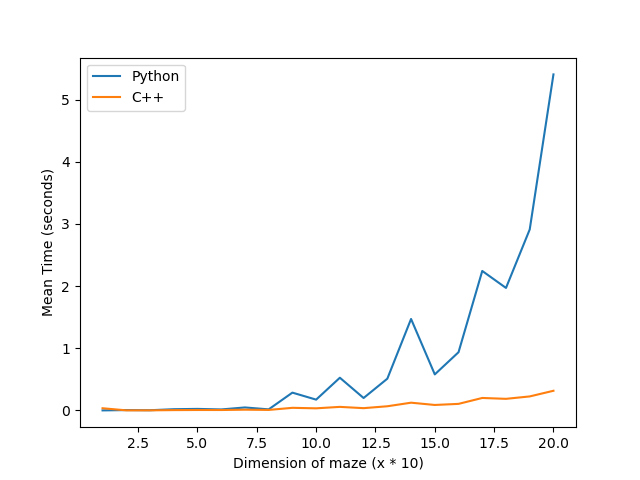

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

In [7]:
%matplotlib notebook

fig = plt.figure()
ax = plt.subplot(111)

x_axis = [i for i in range(1, 21)]

pyt, cppt = exec_times()
pyt = [i/10 for i in pyt]
cppt = [i/10 for i in cppt]

ax.plot(x_axis, pyt, label="Python")
ax.plot(x_axis, cppt, label="C++")
ax.set_xlabel("Dimension of maze (x * 10)")
ax.set_ylabel("Mean Time (seconds)")

plt.legend(loc="upper left")
plt.show()

In [9]:
m = AStar(100, 40, False)
while True:
    try:
        print("trying")
        m = AStar(100, 40, False)
        path, checked = m.solve()
        break
    except:
        continue
solved = [(i.x, i.y) for i in path]
checked = [(i.x, i.y) for i in checked]
cols = {"O": "\x1b[32m█\x1b[0m", "#": "\x1b[30m█\x1b[0m", " ": "\x1b[97m█\x1b[0m", "c": "\x1b[96m█\x1b[0m"}
a = "\n".join(["".join([cols["O"] if (j, i) in solved else (cols["#"] if m.grid[i][j].wall else (cols["c"] if (j, i) in checked else cols[" "])) for j in range(m.cols)]) for i in range(m.rows)])

print(a)

trying
████████████████████████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████████████████████████
████████████████████████████████████████████████████████████████████████████████████

In [6]:
import random
from collections import ChainMap


class MazeCreator:
    def __init__(self, w, h):
        self.width = w
        self.height = h
        self.grid = [
            [
                ("-" if (j + 1) % 2 == 0 else "/") if i % 2 == 0 else ("O" if (j + 1) % 2 == 0 else "|")
                for j in range(self.width + (1 if self.width % 2 == 0 else 0))
            ]
            for i in range(self.height + (1 if self.height % 2 == 0 else 0))
        ]
        # Cell positions, e.g (acc_x, acc_y): (puz_x, puz_y), sequence is 2n + 1
        self.cell_table = dict(ChainMap(*[
            {(i, j): ((i * 2) + 1, (j * 2) + 1) for j in range(len(self.grid) // 2)}
            for i in range(len(self.grid) // 2)
        ]))

    def get_adjacent_walls(self, cell: tuple) -> list:
        """
        Gets walls adjacent to cell
        :param cell: (x, y) coord for cell to check
        :return: Coords of all adjacent walls
        """
        return [i for i in [
            (cell[0] + 1, cell[1]), (cell[0] - 1, cell[1]), (cell[0], cell[1] + 1), (cell[0], cell[1] - 1)
        ] if (0 < i[0] < len(self.grid[0]) - 1 and 0 < i[1] < len(self.grid) - 1) and self.grid[i[1]][i[0]] != " "]

    def create(self, start_pos: tuple) -> None:
        """
        Creates maze using Randomized Prim's algorithm
        Example using 10x10:
        /-/-/-/-/-/
        |X X X X|X|
        / / /-/ / /
        |X|X X|X X|
        /-/ / /-/-/
        |X X|X X X|
        /-/ /-/-/-/
        |X X X X X|
        /-/ /-/-/ /
        |X X X|X X|
        /-/-/-/-/-/

        / = unused vertex, - = horizontal wall, | = vertical wall, ' ' = door
        :param start_pos: (x, y) of start position
        :return: None
        """

        # In form (x, y), therefore must be used as grid[wall[1]][wall[0]]
        puz_cur_pos = (1, 1)
        self.grid[puz_cur_pos[1]][puz_cur_pos[0]] = "X"
        walls = [*self.get_adjacent_walls(puz_cur_pos)]
        while walls:
            wall = random.choice(walls)
            # Vertical wall separating horizontal cells, checks if one isnt visited using xor
            if (self.grid[wall[1]][wall[0] - 1] == "O") ^ (self.grid[wall[1]][wall[0] + 1] == "O"):
                if self.grid[wall[1]][wall[0] - 1] == "O":
                    cell = (wall[0] - 1, wall[1])
                    self.grid[wall[1]][wall[0] - 1] = "X"

                elif self.grid[wall[1]][wall[0] + 1] == "O":
                    cell = (wall[0] + 1, wall[1])
                    self.grid[wall[1]][wall[0] + 1] = "X"
                self.grid[wall[1]][wall[0]] = " "
                walls.extend(self.get_adjacent_walls(cell))

            # Horizontal wall separating vertical cells, checks if one isnt visited using xor
            if (self.grid[wall[1] - 1][wall[0]] == "O") ^ (self.grid[wall[1] + 1][wall[0]] == "O"):
                if self.grid[wall[1] - 1][wall[0]] == "O":
                    cell = (wall[0], wall[1] - 1)
                    self.grid[wall[1] - 1][wall[0]] = "X"

                elif self.grid[wall[1] + 1][wall[0]] == "O":
                    cell = (wall[0], wall[1] + 1)
                    self.grid[wall[1] + 1][wall[0]] = "X"

                self.grid[wall[1]][wall[0]] = " "
                walls.extend(self.get_adjacent_walls(cell))
            walls.remove(wall)
        
        with open("maze.txt", "w") as f:
            f.write("\n".join("".join(i) for i in self.grid))